## Modeling $f(x) = \partial F / \partial x $: Training
Created: January 28, 2024 Harrison B. Prosper and Ali Al Kadhim<br>

### Introduction

In this notebook we approximate the cumulative distribution function $q = F(x)$ using a simple neural network[1] and the probability density function $f(x) = \partial F / \partial x$ using automatic differentiation of the input of the neural network.

### References
  1. Ann Lee *et al.*, https://arxiv.org/abs/2107.03920

In [2]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

# some simple dnn utilities
import dnnutil as ut

%matplotlib inline

device: cpu


In [3]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

In [4]:
datafile = f'../data/traindata_110k.csv.gz'

print('loading %s' % datafile)
df = pd.read_csv(datafile)
print('number of rows:', len(df))

df[:5]

loading ../data/traindata_110k.csv.gz
number of rows: 110000


,x,Z
0,1.069950,1
1,0.493114,0
2,0.966674,1
3,-0.049837,1
4,0.760677,1


### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

In [5]:
# Fraction of the data assigned as test data and validation
tfraction = 5/110 # test fraction, rest for training
vfraction = 5/110
tdata     = df

# Split data into a part for training and a part for testing
train_data, valid_data, test_data = ut.split_data(df, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train set size:        100000
validation set size:     5000
test set size:           5000


### Define model for cdf: $F(x; \omega)$

In [29]:
%%writefile cdf_100k.py

name     = 'cdf_100k'
features = ['x']
target   = 'Z'
nodes    =  25

import torch
import torch.nn as nn

model = nn.Sequential(nn.Linear(len(features), nodes), nn.SiLU(),
                      nn.Linear(nodes, nodes), nn.SiLU(),
                      nn.Linear(nodes, nodes), nn.SiLU(),
                      nn.Linear(nodes, nodes), nn.SiLU(),
                      nn.Linear(nodes, nodes), nn.SiLU(),
                      nn.Linear(nodes, 1), nn.Sigmoid()
                     )

Overwriting cdf_100k.py


### Train!

In [30]:
traces = ([], [], [])
traces_step = 10

cdf_100k
Sequential(
  (0): Linear(in_features=1, out_features=25, bias=True)
  (1): SiLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): SiLU()
  (4): Linear(in_features=25, out_features=25, bias=True)
  (5): SiLU()
  (6): Linear(in_features=25, out_features=25, bias=True)
  (7): SiLU()
  (8): Linear(in_features=25, out_features=25, bias=True)
  (9): SiLU()
  (10): Linear(in_features=25, out_features=1, bias=True)
  (11): Sigmoid()
)
number of parameters: 2676

Iteration vs average loss
iteration train-set valid-set
0        0 0.2498999 0.2498858
10       10 0.2497067 0.2496972
20       20 0.2494877 0.2494866
30       30 0.2492219 0.2492338
40       40 0.2488727 0.2488996
107300720 0.1634813 0.1656572     10720:       720/0.16557895/    10000

stopping early!



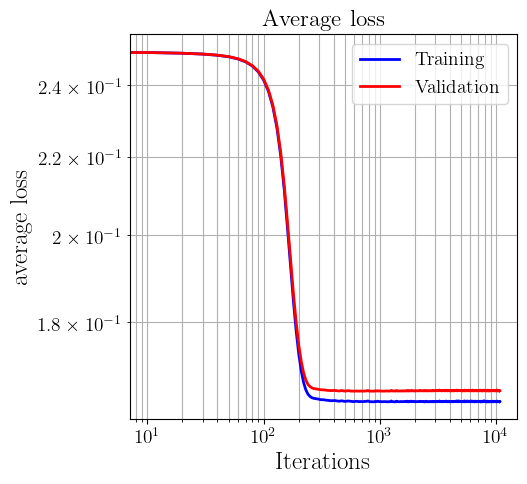

In [31]:
seed = 42
rnd  = np.random.RandomState(seed)
# ----------------------------------------------------------------
Load_model  = False
Train_model = True
# ----------------------------------------------------------------
import cdf_100k as NN
importlib.reload(NN)
name     = NN.name
model    = NN.model
features = NN.features
target   = NN.target

modelfile  = f'{NN.name:s}.dict'
print(name)
print(model)
print(f'number of parameters: {ut.number_of_parameters(model):d}')
print()
# ----------------------------------------------------------------
if Load_model:
    modeldict = torch.load(modelfile)
    NN.model.load_state_dict(modeldict)
    print('load model: %s' % modelfile)
    
if Train_model:
    n_batch       = 1024
    n_iterations  = 500000
    early_stopping= 10000
    learning_rate = 2.e-4
    
    av_loss   = ut.average_quadratic_loss
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    
    traces    = ut.train(model, optimizer, 
                      modelfile, early_stopping,
                      av_loss,
                      ut.get_batch, 
                      train_data, valid_data,
                      features, target,
                      n_batch, 
                      n_iterations,
                      traces,
                      step=traces_step)
    
    ut.plot_average_loss(traces)

### Define a wrapper class around trained model

In [115]:
class TrainedModel:
    def __init__(self, model):
        self.model = model

    def __cdf(self, x):
        # convert to a tensor and compute
        if (type(x) == type(1.0)) or (type(x) == type(1)):
            X = torch.Tensor(np.array([x]))
        else:
            X = torch.Tensor(np.array([x])).transpose(1, 0)
            
        X.requires_grad_(True)
        
        self.model.eval() 
        return self.model(X).view(-1), X 
        
    def cdf(self, x): 
        F, _ = self.__cdf(x)
        
        Y = F.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y

    def pdf(self, x):
        F, X = self.__cdf(x)

        dFdX = torch.autograd.grad(outputs=F, inputs=X, 
                               grad_outputs=torch.ones_like(F),
                               #allow_unused=True, 
                               #retain_graph=True, 
                               create_graph=True)[0]
    
        Y = dFdX.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y  

### Plot approximate and exact cdf $\mathbb{P}[X^\prime \leq X]$

In [116]:
def plot_cdf(x, y1, y2, ftsize=18):

    xmin, xmax = x[0], x[-1]
    ymin, ymax = 0, 1
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows, ncols, index)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.plot(x, y1, 'b', lw=2, label='approx')
    ax.plot(x, y2, 'r', lw=2, linestyle='dashed', label='exact')

    ax.set_xlabel('$x$', fontsize=ftsize)
    ax.set_ylabel('$q(x)$', fontsize=ftsize)
    
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper left')

    plt.show()

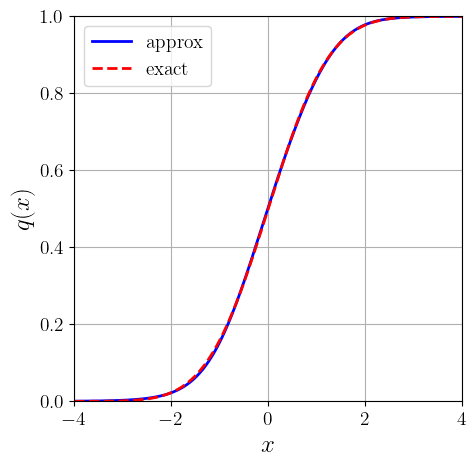

In [137]:
tmodel = TrainedModel(model)

M  = 1001
xmin, xmax = -4, 4

X = np.linspace(xmin, xmax, M)
q = tmodel.cdf(X)
p = st.norm.cdf(X)

plot_cdf(X, q, p)

### Plot $f(x) = \partial F(x) / \partial x$

In [138]:
def plot_pdf(x, y1, y2, ftsize=18):

    xmin, xmax = x[0], x[-1]
    ymin, ymax = 0, 0.5
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows, ncols, index)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.plot(x, y1, 'b', lw=2, label='approx')
    ax.plot(x, y2, 'r', lw=1, linestyle='dashed', label='exact')
    
    ax.set_xlabel('$x$', fontsize=ftsize)
    ax.set_ylabel('$f(x) = \partial F(x) / \partial x$', fontsize=ftsize)
    
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper left')

    plt.show()

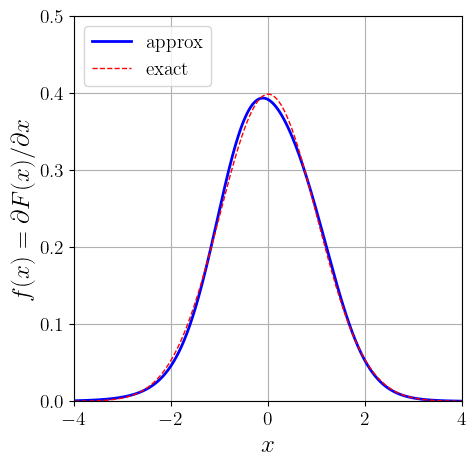

In [139]:
f1 = tmodel.pdf(X)
f2 = st.norm.pdf(X)
plot_pdf(X, f1, f2)

### Plot calibration curve and residuals

Given an array of numbers $a$ and an array of probabilities $p$, the function
```python
    q = np.quantile(a, p)
```
returns the *quantiles* of $a$, that is, for each probability in $p$ the $\texttt{numpy}$ function returns the value of $a$ for which $p = \mathbb{P}[a^\prime \leq a]$. (The quantile function is just the inverse function of the cumulative distribution function (cdf)). Therefore, if we can model the correction function $p = C(q)$ accurately, where $q$ is the estimated cdf and $p = F(x)$ is the exact cdf, it can be used to improve the estimated cdf.  We'll write the function $C(q)$ as follows 
\begin{align}
q & = C(q), \nonumber\\
    & = q + \Delta C(q) ,
\end{align}
and model the residual function $\Delta C(q)$ with a polynomial.

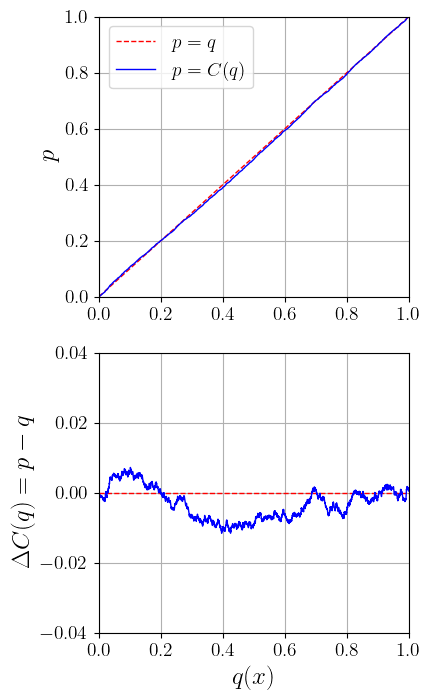

In [140]:
def plot_cc(q, p, ftsize=18):

    xmin, xmax = 0, 1
    ymin, ymax = 0, 1
    
    # create an empty figure
    fig = plt.figure(figsize=(4, 8))
    fig.tight_layout()
    
    # add subplots to it
    nrows, ncols = 2,1
    ax1 = fig.add_subplot(nrows, ncols, 1)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.set_ylabel('$p$', fontsize=ftsize)
    
    ax2 = fig.add_subplot(nrows, ncols, 2)
    dp  = 0.04
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-dp, dp)
    ax2.set_xlabel('$q(x)$', fontsize=ftsize)
    ax2.set_ylabel('$\Delta C(q) = p - q$', fontsize=ftsize)
    
    ax1.plot([0, 1], [0, 1], 'r', 
             linewidth=1, 
             linestyle='dashed', 
             label='$p = q$')
    ax1.plot(q, p, 'b', linewidth=1, 
             label='$p = C(q)$')
    ax1.grid(True, which="both", linestyle='-')
    ax1.legend()
    
    ax2.plot([0, 1], [0, 0], 'r', linewidth=1, linestyle='dashed')
    ax2.plot(q, p-q, 'b', linewidth=1)
    ax2.grid(True, which="both", linestyle='-')

    plt.show()

# for every x compute an estimate of the probability P[x' <= x]

a = tmodel.cdf(test_data.x)

# then map from p to the estimated probabilities q
p = np.linspace(0, 1, len(a))
q = np.quantile(a, p)

plot_cc(q, p)

### Model the residuals $p - q = \Delta C(q)$ with a polynomial

In [141]:
import scipy.optimize as op

def poly(X, A):
    y  = 0.0
    x  = np.array(X)
    for a in A:
        x *= X
        y += a * x
    return y

# 1st derivative of polynomials
def dpoly(X, A):
    y  = 0.0
    x  = np.ones(len(X))
    n  = 1
    for a in A:
        x *= X
        n += 1
        y += n * a * x
    return y

In [142]:
def plot_dc(q, p, res=None, ftsize=18):
    
    dp = 0.04
    xmin, xmax = 0, 1
    ymin, ymax =-dp, dp
    
    # create an empty figure
    fig = plt.figure(figsize=(4, 4))
    fig.tight_layout()
    
    # add subplots to it
    nrows, ncols = 1,1
    ax = fig.add_subplot(nrows, ncols, 1)
    dp  = 0.04
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('$q(x)$', fontsize=ftsize)
    ax.set_ylabel('$\Delta C(q) = p - q$', fontsize=ftsize)
    
    ax.plot([0, 1], [0, 0], 'r', linewidth=1, linestyle='dashed')
    ax.plot(q, p-q, 'b', linewidth=1, label='data')

    if res != None:
        y = poly(q, res.x)
        ax.plot(q, y,   'k', linewidth=1, label='fit')
    ax.grid(True, which="both", linestyle='-')

    plt.show()

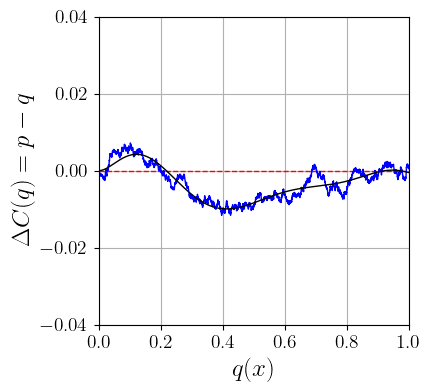

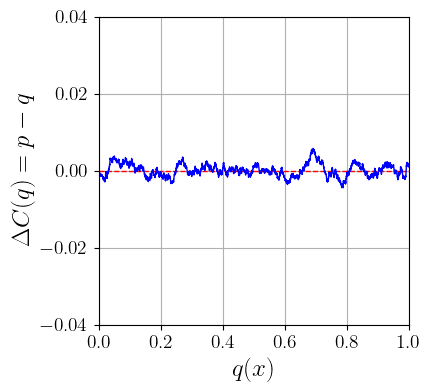

In [143]:
def nll(pars, *args):
    x, y, w = args
    F = w*(y - poly(x, pars))**2
    return F.sum()

guess  = np.array([0.]*8)
results= op.minimize(nll, guess, args=(q, p-q, 1))

plot_dc(q, p, results)

# plot residuals of corrected cdf
Q = q + poly(q, results.x)
plot_dc(Q, p)

### Plot corrected pdf

Since the corrected cdf is given by $Q = q + \text{poly}(q)$, the correctedt pdf, $f^\prime(x)$, is given by 
\begin{align}
    f^\prime(x) & = \frac{\partial Q}{\partial x}, \nonumber\\
        & = \left(1 + \frac{d\text{poly}(q)}{d q} \right) \frac{\partial q(x)}{\partial x},
\end{align}

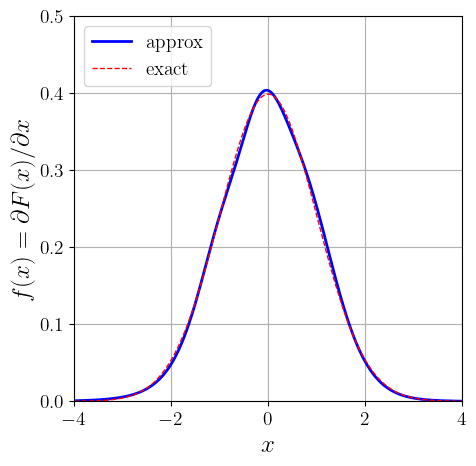

In [144]:
q = tmodel.cdf(X)
f = tmodel.pdf(X)
f1 = (1 + dpoly(q, results.x)) * f
f2 = st.norm.pdf(X)
plot_pdf(X, f1, f2)